<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Parameters" data-toc-modified-id="Parameters-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Parameters</a></span></li><li><span><a href="#Corresponding-JSON-file-to-extract-labels" data-toc-modified-id="Corresponding-JSON-file-to-extract-labels-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Corresponding JSON file to extract labels</a></span></li><li><span><a href="#Encoding-pipline-(text-embedding-+-layout-embedding)" data-toc-modified-id="Encoding-pipline-(text-embedding-+-layout-embedding)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Encoding pipline (text embedding + layout embedding)</a></span><ul class="toc-item"><li><span><a href="#To-save-encoded-inputs-since-RAM-compacity-is-insufficient" data-toc-modified-id="To-save-encoded-inputs-since-RAM-compacity-is-insufficient-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>To save encoded inputs since RAM compacity is insufficient</a></span></li></ul></li><li><span><a href="#Read-and-concatenate-encoded-inputs" data-toc-modified-id="Read-and-concatenate-encoded-inputs-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Read and concatenate encoded inputs</a></span></li><li><span><a href="#Advanced-model-construction-(LiLT)" data-toc-modified-id="Advanced-model-construction-(LiLT)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Advanced model construction (LiLT)</a></span><ul class="toc-item"><li><span><a href="#Models'-parameters" data-toc-modified-id="Models'-parameters-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Models' parameters</a></span></li><li><span><a href="#Training-process" data-toc-modified-id="Training-process-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Training process</a></span></li></ul></li><li><span><a href="#Validate-model" data-toc-modified-id="Validate-model-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Validate model</a></span></li><li><span><a href="#Saving-model" data-toc-modified-id="Saving-model-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Saving model</a></span></li><li><span><a href="#Load-trained-model-to-predict" data-toc-modified-id="Load-trained-model-to-predict-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Load trained model to predict</a></span></li><li><span><a href="#Single-tests" data-toc-modified-id="Single-tests-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Single tests</a></span></li></ul></div>

# Parameters

In [12]:
import torch

def sci_format(number_in_scientific_notation):
  # Convert the number to a string in scientific notation
  number_str = "{:.1e}".format(number_in_scientific_notation)

  # Check if the exponent contains a leading zero
  if "e-0" in number_str:
      # Remove the leading zero from the exponent
      formatted_exponent = number_str.replace("e-0", "e-")
  else:
      formatted_exponent = number_str

  # Check if the formatted exponent has a decimal point
  if "." in formatted_exponent:
      # Remove the decimal point and extra zeros from the exponent
      formatted_number_str = formatted_exponent.replace(".0e", "e").replace("0e", "e")
  else:
      formatted_number_str = formatted_exponent
  return formatted_number_str

# parameters for adjestment
# labels_json = 'backup_23148_4374.json'
labels_json = 'backup_23148_4657.json'
# maximun token sequence length
MAX_LENGTH_SEQ = 128
# The DataLoader needs to know our batch size for training, so we specify it
# here. For fine-tuning BERT on a specific task, the authors recommend a batch
# size of 16 or 32.
batch_size = 8
# Number of training epochs. The BERT authors recommend between 2 and 4.
# Depends on training criterian
epochs = 6

learning_rate = 6e-6 # args.learning_rate - default is 5e-5, our notebook would adjust
eps = 1e-6 # args.adam_epsilon  - default is 1e-8.
lr_format = sci_format(learning_rate)
# training records
# a = advance, text = textual approachs, e = epoch, s = sequence length, lr = learning rate
runs_name = f'a_mul_e{epochs}_s{MAX_LENGTH_SEQ}_lr{lr_format}'
print(runs_name)

# Saving training process steps and validation process steps
runs_output = f"./output/runs/{runs_name}"
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()
output_dir = f'./output/checkpoints/{runs_name}'

# encoded input
num_imgs = labels_json.split('.')[0].split('_')[-1]
encoded_inp = f'{num_imgs}_seq{MAX_LENGTH_SEQ}'

# If there's a GPU available...

if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

a_mul_e6_s128_lr6e-6
No GPU available, using the CPU instead.


# Corresponding JSON file to extract labels

In [13]:
import pandas as pd
import numpy as np
import ast
import re
import os
def convert_to_list(data):
    return ast.literal_eval(data)

os.chdir('./')
current_path = os.getcwd()
text_path = os.path.join(current_path, 'alignment_pptx_list.csv')
# Since it take too much time on traversal ppt files, Easily to import the dataframe from the csv file
df_da = pd.read_csv(text_path, converters={'shape_type': convert_to_list})
df_da = df_da[~df_da['contents'].isnull()]

In [14]:
# filter out less than 4 words
df_da['word_count'] = df_da['contents'].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)
df_few_words = df_da[~(df_da['word_count'] <= 4)]
df_few_words.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23148 entries, 0 to 26467
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file_name   23148 non-null  object
 1   page_num    23148 non-null  int64 
 2   shape_type  23148 non-null  object
 3   contents    23148 non-null  object
 4   word_count  23148 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.1+ MB


In [15]:
df_json = pd.read_json(os.path.join(current_path, 'output','LABELS', labels_json))
# have done for annotations
df_json = df_json[df_json['annotations'].apply(lambda x: len(x) != 0)]
# annotation results exist
df_json = df_json[df_json['annotations'].apply(lambda x: len(x[0]['result']) != 0)]
# 22348 for 13th slide
count = 13

df_few_words['label'] = ''

for idx, row in enumerate(df_json.iterrows()):
  slide = row[1]
  image_path = slide['data']['image']
  choice = slide['annotations'][0]['result'][0]['value']['choices'][0]

  # print(image_path, choice)
  if image_path.find('22348')!=-1:
    # print(image_path, choice)
    new_image_name = image_path.split('.')[0] + '_' + str(count) + '.PNG'
    slide['data']['image'] = new_image_name
    image_path = new_image_name
    print(image_path)
    count += 1

  # get page number
  if image_path.split('.')[0].split('_')[-1].isdigit():
    page = int(image_path.split('.')[0].split('_')[-1])
  else:
    page = 0

  # given 'Angebot\ktr' as a condition
  ktr = image_path.split('-')[1].split('_')[0]
  ktr = 'Angebot\\'+ ktr
  ktr = re.escape(ktr)

  # some issues that it should modify manually for updating
  if (image_path.find('22348')!=-1 and page == 13):
      print('QQ')
      df_few_words.loc[(df_few_words['file_name'].str.contains('22348')) & (df_few_words['page_num'] == page), 'label'] = 'Initial Situation'
      continue
  elif (image_path.find('22348')!=-1 and page == 14):
      df_few_words.loc[(df_few_words['file_name'].str.contains('22348')) & (df_few_words['page_num'] == page), 'label'] = 'Target Situation'
      continue
  elif (image_path.find('22348')!=-1 and page == 15):
      print('hard code fill in')
      df_few_words.loc[(df_few_words['file_name'].str.contains('22348')) & (df_few_words['page_num'] == 11), 'label'] = 'Reference Overview'
      slide['data']['image'] = image_path.split('.')[0] + '_' + str(11) + '.PNG'
      continue
  elif (image_path.find('22348')!=-1 and page == 16):
      df_few_words.loc[(df_few_words['file_name'].str.contains('22348')) & (df_few_words['page_num'] == 1), 'label'] = 'Offer Title'
      slide['data']['image'] = image_path.split('.')[0] + '_' + str(1) + '.PNG'
      continue
  elif (image_path.find('22348')!=-1 and page == 17):
      df_few_words.loc[(df_few_words['file_name'].str.contains('22348')) & (df_few_words['page_num'] == 29), 'label'] = 'Working Package Examples'
      slide['data']['image'] = image_path.split('.')[0] + '_' + str(29) + '.PNG'
      continue
  elif (image_path.find('22348')!=-1 and page == 18):
      df_few_words.loc[(df_few_words['file_name'].str.contains('22348')) & (df_few_words['page_num'] == 28), 'label'] = 'Working Package Examples'
      slide['data']['image'] = image_path.split('.')[0] + '_' + str(28) + '.PNG'
      continue
  elif (image_path.find('22348')!=-1 and page == 19):
      df_few_words.loc[(df_few_words['file_name'].str.contains('22348')) & (df_few_words['page_num'] == 27), 'label'] = 'Others'
      slide['data']['image'] = image_path.split('.')[0] + '_' + str(27) + '.PNG'
      continue
  elif (image_path.find('22348')!=-1 and page == 20):
      df_few_words.loc[(df_few_words['file_name'].str.contains('22348')) & (df_few_words['page_num'] == 16), 'label'] = 'Working Package Overview'
      slide['data']['image'] = image_path.split('.')[0] + '_' + str(16) + '.PNG'
      continue
  elif (image_path.find('22348')!=-1 and page == 21):
      df_few_words.loc[(df_few_words['file_name'].str.contains('22348')) & (df_few_words['page_num'] == 30), 'label'] = 'Working Package Description'
      slide['data']['image'] = image_path.split('.')[0] + '_' + str(30) + '.PNG'
      continue
  elif (image_path.find('22348')!=-1 and page == 22):
      df_few_words.loc[(df_few_words['file_name'].str.contains('22348')) & (df_few_words['page_num'] == 21), 'label'] = 'Working Package Description'
      slide['data']['image'] = image_path.split('.')[0] + '_' + str(21) + '.PNG'
      continue

  df_few_words.loc[(df_few_words['file_name'].str.contains(ktr)) & (df_few_words['page_num'] == page), 'label'] = choice

df_few_words.info()

C:\Users\Kun\AppData\Local\Temp\ipykernel_23392\4090076410.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_few_words['label'] = ''


/data/upload/3/30b5074c-22348_Projektskizze_Benchmarking_und_Effizienzsteigerung_in_den_Zentra_EVP8fho_13.PNG
QQ
/data/upload/3/33344dac-22348_Projektskizze_Benchmarking_und_Effizienzsteigerung_in_den_Zentra_iHJAu6y_14.PNG
<class 'pandas.core.frame.DataFrame'>
Int64Index: 23148 entries, 0 to 26467
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file_name   23148 non-null  object
 1   page_num    23148 non-null  int64 
 2   shape_type  23148 non-null  object
 3   contents    23148 non-null  object
 4   word_count  23148 non-null  int64 
 5   label       23148 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.2+ MB


In [7]:
QQ = df_few_words[df_few_words['label'] != '']

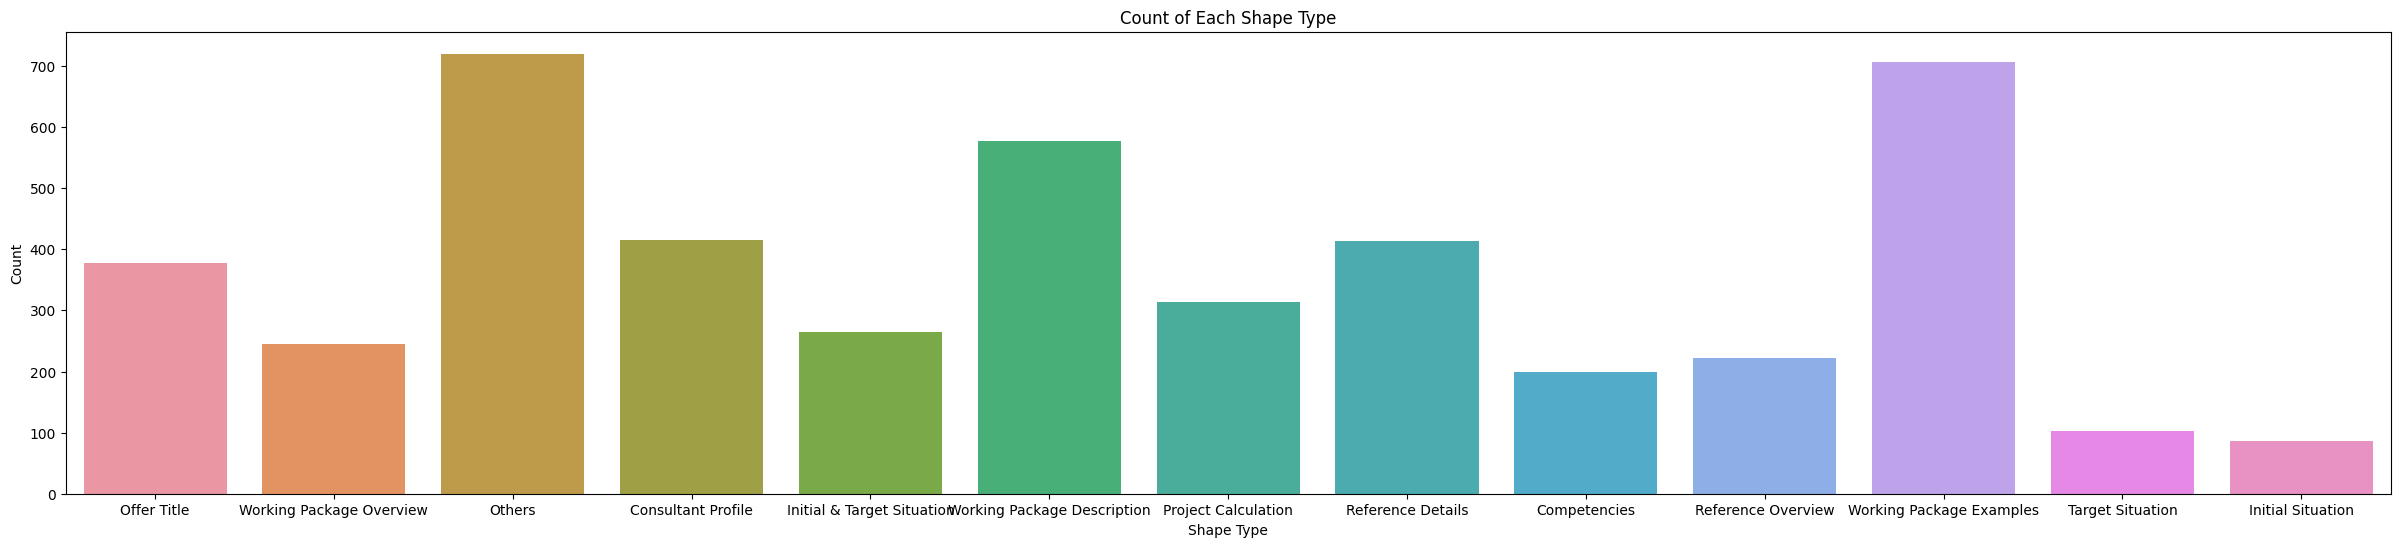

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# 假設您的 DataFrame 稱為 df
# 這邊假設 'shape_type' 是類別，您可以根據實際情況更換為其他欄位名稱

# 設定圖形大小
plt.figure(figsize=(30, 6))

# 使用 seaborn 的 countplot 來繪製
sns.countplot(x='label', data=QQ)

# 設定標題與軸標籤
plt.title('Count of Each Shape Type')
plt.xlabel('Shape Type')
plt.ylabel('Count')

# 顯示圖形
plt.show()

In [16]:
from PIL import Image

imgs_path = f'./output/FewWordImg'
file_list = [file for file in os.listdir(imgs_path) if file.endswith('.PNG')]
png_dict = {}
imgs = []
pngs = [] # with file name and label

# since the string names are too long, we would like to ignore them. So pick snippet as key words
long_name_list = ['20830_Further_Support_Enhancing']

for i in file_list:
  ktr, page = i.split('_')[0], i.split('_')[-1].split('.')[0]
  png_page = int(page)
  png_dict[(ktr, png_page)] = i

# corressponding
for row in df_json.iterrows():
  jump = False
  image_path = row[1]['data']['image']

  for long_name in long_name_list:
      if long_name in image_path:
        # print(f'ignore: {image_path}')
        jump = True
        break

  # ignore long string file name
  if jump:
    continue

  ktr = image_path.split('-')[1].split('_')[0]
  page_num = int(image_path.split('/')[-1].split('.')[0].split('_')[-1])
  choice = row[1]['annotations'][0]['result'][0]['value']['choices'][0]
  # we do not consider 'Others' category
  if choice!= 'Others':
    # open images
    file_name = png_dict[(ktr, page_num)]
    read_path = os.path.join(imgs_path, file_name)
    # if we've already prepared encoded inputs, imgs(list) is not necessary.
    # ////////////////////////////////////////////////
    # imgs.append(Image.open(read_path).convert('RGB'))
    # ///////////////////////////////////////////////
    pngs.append([file_name, choice])

# Encoding pipline (text embedding + layout embedding)

If you have **a large number of pictures**, it's a good idea to finish encoding them first. Otherwise, regular computer resources might be limited, leading to memory issues.

In [ ]:
# ubuntu
!sudo apt install -y tesseract-ocr
# python
!pip install pytesseract transformers datasets seqeval tensorboard --upgrade

## To save encoded inputs since RAM compacity is insufficient

In [10]:

import torch
from transformers import LayoutLMv3FeatureExtractor, LayoutXLMTokenizerFast, LayoutLMv3Processor, LayoutLMv3TokenizerFast, LayoutLMv3ImageProcessor

# feature_extractor = LayoutLMv3ImageProcessor(ocr_lang="eng+deu")
# tokenizer = LayoutLMv3TokenizerFast.from_pretrained("nielsr/lilt-xlm-roberta-base")
# processor = LayoutLMv3Processor(feature_extractor, tokenizer)
# num_images = len(imgs)
# # split batch to reduce RAM consumption
# b_size = 1000


# for i in range(0, num_images, b_size):
#   encoded_inputs = processor(imgs[i:i+b_size],
#                              return_tensors="pt",
#                              max_length = 512,    # Pad & truncate all sentences.
#                              padding = 'max_length',
#                              truncation = True,
#                       )
 
#   output_file_path = f"output/encoded_inputs/encoded_inputs_multi_len{MAX_LENGTH_SEQ}_{i}.pt"
#   with open(output_file_path, 'wb') as output_file:
#         torch.save(encoded_inputs, output_file)



The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLMRobertaTokenizer'. 
The class this function is called from is 'LayoutLMv3TokenizerFast'.


# Read and concatenate encoded inputs

In [17]:
class_map = {'Competencies': 0,
             'Consultant Profile':1,
             'Initial & Target Situation':2,
             'Initial Situation':3,
             'Offer Title':4,
             'Project Calculation':5,
             'Reference Details':6,
             'Reference Overview':7,
             'Target Situation':8,
             'Working Package Description':9,
             'Working Package Examples':10,
             'Working Package Overview':11,
             'Others':12
        }


label2id = {}
id2label = {}

for class_name, id in class_map.items():
    label2id[class_name] = id
    id2label[id] = class_name


labels = np.array([class_map[v[1]] for v in pngs])
labels = torch.tensor(labels)


In [19]:
from transformers import BatchEncoding
encoded_path = f'./output/encoded_inputs/{encoded_inp}'

pt_list = [file for file in os.listdir(encoded_path) if file.endswith('.pt')]

combined_encode_lists = []
for i in pt_list:
  path = os.path.join(encoded_path, i)
  LKK = torch.load(path)
  combined_encode_lists.append(LKK)


merged_encoded_inputs = {
    key: torch.cat([enc_input[key] for enc_input in combined_encode_lists], dim=0)
    for key in combined_encode_lists[0].keys()
}

merged_encoded_inputs.keys()

dict_keys(['input_ids', 'attention_mask', 'bbox', 'pixel_values'])

In [14]:
merged_encoded_inputs['bbox'][:,:,0].size()

torch.Size([3763, 512])

In [20]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
inputs_ids = merged_encoded_inputs['input_ids']
attention_masks = merged_encoded_inputs['attention_mask']
b_boxes = merged_encoded_inputs['bbox']
dataset = TensorDataset(inputs_ids, attention_masks, b_boxes, labels)

torch.manual_seed(42)
# Calculate the number of samples to include in each set.
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Divide the dataset by randomly selecting samples.
train_dataset, temp_dataset = random_split(dataset, [train_size, len(dataset) - train_size])
val_dataset, test_dataset = random_split(temp_dataset, [val_size, test_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} testing samples'.format(test_size))



3,010 training samples
  376 validation samples
  377 testing samples


In [21]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
)

testing_dataloader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=batch_size
)

# save tensor for performance evaluation
# torch.save(testing_dataloader, './mul_test_dataloader.pth')

# Advanced model construction (LiLT)

In [12]:
from transformers import LiltForSequenceClassification, AdamW, LiltConfig
from torch.utils.tensorboard import SummaryWriter
# Load LiltForSequenceClassification, the pretrained LiLt model with a single
# linear classification layer on top.
model = LiltForSequenceClassification.from_pretrained(
        "nielsr/lilt-xlm-roberta-base", # Use th
        # "SCUT-DLVCLab/lilt-infoxlm-base",
        num_labels = 13, # The number of output labels--12 for multi-class classification.
        label2id=label2id,
        id2label=id2label,
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
)

# model.cuda()

Some weights of the model checkpoint at nielsr/lilt-xlm-roberta-base were not used when initializing LiltForSequenceClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing LiltForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LiltForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LiltForSequenceClassification were not initialized from the model checkpoint at nielsr/lilt-xlm-roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be ab

## Models' parameters

In [13]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The LiLT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[14:46]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The LiLT model has 402 different named parameters.

==== Embedding Layer ====

lilt.embeddings.word_embeddings.weight                  (250002, 768)
lilt.embeddings.position_embeddings.weight                (514, 768)
lilt.embeddings.token_type_embeddings.weight                (1, 768)
lilt.embeddings.LayerNorm.weight                              (768,)
lilt.embeddings.LayerNorm.bias                                (768,)
lilt.layout_embeddings.x_position_embeddings.weight      (1024, 128)
lilt.layout_embeddings.y_position_embeddings.weight      (1024, 128)
lilt.layout_embeddings.h_position_embeddings.weight      (1024, 128)
lilt.layout_embeddings.w_position_embeddings.weight      (1024, 128)
lilt.layout_embeddings.box_position_embeddings.weight     (514, 192)
lilt.layout_embeddings.box_linear_embeddings.weight       (192, 768)
lilt.layout_embeddings.box_linear_embeddings.bias             (192,)
lilt.layout_embeddings.LayerNorm.weight                       (192,)
lilt.layout_embeddings.

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = learning_rate, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = eps # args.adam_epsilon  - default is 1e-8.
                )

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
import time
import datetime

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
  '''
  Takes a time in seconds and returns a string hh:mm:ss
  '''
  # Round to the nearest second.
  elapsed_rounded = int(round((elapsed)))

  # Format as hh:mm:ss
  return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Compute the class weights
class_weights = compute_class_weight('balanced', classes = np.unique(labels.numpy()), y = labels.numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Loss function
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

## Training process

In [ ]:
import random
import numpy as np

writer = SummaryWriter(runs_output)

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Define early stopping variables
early_stop = False
best_val_loss = float('inf')  # Initialize with a high value
patience = 5  # Number of epochs to wait before stopping if no improvement
no_improvement_count = 0  # Counter for epochs with no improvement

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    for step, batch in enumerate(train_dataloader):

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: bounding boxes
        #   [3]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_box = batch[2].to(device)
        b_labels = batch[3].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        outputs = model(input_ids = b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        bbox = b_box,
                        labels=b_labels)

        # loss = outputs.loss
        logits = outputs.logits
        loss = criterion(logits, b_labels)

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += loss.item()


        # if step % 40 == 39: # every 40 mini-batches....
        if step % 40 == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          elapsed = format_time(time.time() - t0)
          # Report progress.
          print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

          # ========================================
          #               Validation
          # ========================================
          # After the completion of each training epoch, measure our performance on
          # our validation set.
          print("")
          print(f"Running Validation...({step // 40})")

          t1 = time.time()

          # Put the model in evaluation mode--the dropout layers behave differently
          # during evaluation.
          model.eval()

          # Tracking variables
          total_eval_accuracy = 0
          total_eval_loss = 0
          predictions = []
          true_labels = []

          # Evaluate data for one epoch
          for batch in validation_dataloader:

              # Unpack this training batch from our dataloader.
              #
              # As we unpack the batch, we'll also copy each tensor to the GPU using
              # the `to` method.
              #
              # `batch` contains three pytorch tensors:
              #   [0]: input ids
              #   [1]: attention masks
              #   [2]: bounding boxes
              #   [3]: labels
              b_input_ids = batch[0].to(device)
              b_input_mask = batch[1].to(device)
              b_box = batch[2].to(device)
              b_labels = batch[3].to(device)

              # Tell pytorch not to bother with constructing the compute graph during
              # the forward pass, since this is only needed for backprop (training).
              with torch.no_grad():

                  # Forward pass, calculate logit predictions.
                  # token_type_ids is the same as the "segment ids", which
                  # differentiates sentence 1 and 2 in 2-sentence tasks.
                  # The documentation for this `model` function is here:
                  # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                  # Get the "logits" output by the model. The "logits" are the output
                  # values prior to applying an activation function like the softmax.

                  outputs = model(b_input_ids,
                                  token_type_ids=None,
                                  attention_mask=b_input_mask,
                                  bbox = b_box,
                                  labels=b_labels)

                #   loss = outputs.loss
                  logits = outputs.logits
                  loss = criterion(logits, b_labels)

              # Accumulate the validation loss.
              total_eval_loss += loss.item()

              # Move logits and labels to CPU
              logits = logits.detach().cpu().numpy()
              label_ids = b_labels.to('cpu').numpy()

              # Accumulate the predictions and true labels
              predictions.extend(np.argmax(logits, axis=1))
              true_labels.extend(label_ids)

              # Calculate the accuracy for this batch of test sentences, and
              # accumulate it over all batches.
              total_eval_accuracy += flat_accuracy(logits, label_ids)



          # Calculate the average loss over mini-batches.
          avg_train_loss = total_train_loss / 40

          # Calculate the average loss over all of the batches.
          avg_val_loss = total_eval_loss / len(validation_dataloader)


          # Report the final accuracy for this validation run.
          avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
          print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

          # Measure how long the validation run took.
          validation_time = format_time(time.time() - t1)

          print("  Validation Loss: {0:.2f}".format(avg_val_loss))
          print("  Validation took: {:}".format(validation_time))

          # Log the running loss averaged per batch
          writer.add_scalars('Training vs. Validation Loss',
                            { 'Training' : avg_train_loss, 'Validation' : avg_val_loss },
                                epoch_i * len(train_dataloader) + step)

          total_train_loss = 0.0


          # Check if validation loss improved
          if avg_val_loss < best_val_loss:
              best_val_loss = avg_val_loss
              no_improvement_count = 0
          else:
              no_improvement_count += 1

          # Check if early stopping condition is met
          if (no_improvement_count >= patience) and early_stop:
              print(f"Early stopping after {epoch_i + 1} epochs without improvement.")
              break  # Exit the training loop



    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # Check if early stopping condition is met
    if (no_improvement_count >= patience) and early_stop :
      print(f"Early stopping after {epoch_i + 1} epochs without improvement.")
      break  # Exit the training loop



print('Finished Training')
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
writer.flush()

# Validate model

In [ ]:
from sklearn.metrics import classification_report
# Convert the predictions and true labels to numpy arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Generate the classification report
report = classification_report(true_labels, predictions, digits = 4,target_names=['Competencies[0]',
                                                                        'Consultant Profile[1]',
                                                                        'Initial & Target Situation[2]',
                                                                        'Initial Situation[3]',
                                                                        'Offer Title[4]',
                                                                        'Project Calculation[5]',
                                                                        'Reference Details[6]',
                                                                        'Reference Overview[7]',
                                                                        'Target Situation[8]',
                                                                        'Working Package Description[9]',
                                                                        'Working Package Examples[10]',
                                                                        'Working Package Overview[11]',
                                                                        'Others[12]'])

# Print the classification report
print(report)

                                precision    recall  f1-score   support

               Competencies[0]     1.0000    0.9474    0.9730        19
         Consultant Profile[1]     1.0000    1.0000    1.0000        34
 Initial & Target Situation[2]     0.9412    0.9412    0.9412        17
          Initial Situation[3]     0.8000    0.6667    0.7273         6
                Offer Title[4]     1.0000    0.9535    0.9762        43
        Project Calculation[5]     1.0000    0.9000    0.9474        30
          Reference Details[6]     0.9091    0.9756    0.9412        41
         Reference Overview[7]     0.9600    0.9600    0.9600        25
           Target Situation[8]     0.9000    0.9000    0.9000        10
Working Package Description[9]     0.9077    0.9365    0.9219        63
  Working Package Examples[10]     0.8732    0.9254    0.8986        67
  Working Package Overview[11]     0.8947    0.8095    0.8500        21

                      accuracy                         0.9335 

# Saving model

In [ ]:
from transformers import  LayoutLMv3TokenizerFast
tokenizer = LayoutLMv3TokenizerFast.from_pretrained("nielsr/lilt-xlm-roberta-base")
# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

# Load trained model to predict

In [22]:
from transformers import LiltForSequenceClassification

# Load a trained model and vocabulary that you have fine-tuned
model = LiltForSequenceClassification.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)

LiltForSequenceClassification(
  (lilt): LiltModel(
    (embeddings): LiltTextEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (layout_embeddings): LiltLayoutEmbeddings(
      (x_position_embeddings): Embedding(1024, 128)
      (y_position_embeddings): Embedding(1024, 128)
      (h_position_embeddings): Embedding(1024, 128)
      (w_position_embeddings): Embedding(1024, 128)
      (box_position_embeddings): Embedding(514, 192, padding_idx=1)
      (box_linear_embeddings): Linear(in_features=768, out_features=192, bias=True)
      (LayerNorm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LiltEncoder(
      (layer): ModuleList(
        (0-11): 12 x

In [26]:
from sklearn.metrics import classification_report
# Prediction on test set
# print('Predicting labels for {:,} test sentences...'.format(test_size))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in testing_dataloader:
  # Add batch to GPU
  # batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  # b_input_ids, b_input_mask, b_labels = batch
  b_input_ids = batch[0].to(device)
  b_input_mask = batch[1].to(device)
  b_box = batch[2].to(device)
  b_labels = batch[3].to(device).long()



  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs =  model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        bbox = b_box,
                        labels=b_labels)


  # loss = outputs.loss
  logits = outputs.logits
  loss = criterion(logits, b_labels)


  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  # predictions.extend(np.argmax(logits, axis=1))
  # true_labels.extend(label_ids)
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

# print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

print(predictions)
print(true_labels)

    DONE.
[array([[ 6.1448417e+00, -3.9716747e-01, -1.3255917e+00, -3.4249887e-01,
        -6.7178875e-01, -4.6652037e-01, -4.1083193e-01, -5.8491403e-01,
        -3.6547378e-01, -1.0890996e+00, -7.2752213e-01, -1.0662458e+00],
       [-5.4798651e-01, -1.0410248e+00, -1.2267622e+00, -4.9663782e-01,
        -5.3875071e-01, -4.9791780e-01,  6.8559165e+00, -8.2589322e-01,
        -4.9259659e-02, -5.6687504e-01, -1.1091313e+00, -1.7711110e-02],
       [-1.0101787e+00, -4.1565746e-01, -2.9493380e-01, -4.4664457e-03,
        -6.9476002e-01, -1.0148387e+00, -7.1269441e-01, -5.4560930e-01,
        -8.4284902e-01,  7.2926359e+00, -6.6574246e-01, -6.0983747e-01],
       [-2.5706601e-01, -8.8200593e-01, -1.0532480e+00, -4.6278217e-01,
        -3.6379647e-01, -6.7489928e-01,  6.8246212e+00, -7.0978045e-01,
        -1.8547843e-01, -7.3461556e-01, -7.9046309e-01, -5.2342260e-01],
       [-1.3927799e-01,  6.9095135e+00, -9.5925730e-01, -5.1540571e-01,
        -3.9806926e-01, -9.0883118e-01, -9.208136

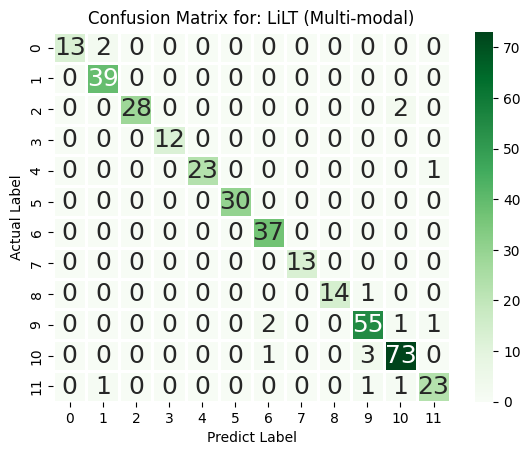

In [27]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y_test, prediction, ML_modelName, cmap):
    cm = confusion_matrix(y_test, prediction)
    
    ax = sns.heatmap(cm, 
              annot=True, 
              annot_kws={'size':18,'weight':'normal'},
              fmt='.20g', 
              cmap=cmap, 
              cbar_kws={'shrink':1},
              linewidths=2)
    
    plt.title("Confusion Matrix for: " + ML_modelName)
    plt.ylabel("Actual Label")
    plt.xlabel("Predict Label")
    cbar = ax.collections[0].colorbar
    plt.show()

predictions_flat = np.argmax(np.vstack(predictions), axis=1)
true_labels_flat = np.concatenate(true_labels)
plot_confusion_matrix(true_labels_flat, predictions_flat, "LiLT (Multi-modal)", plt.cm.Greens)

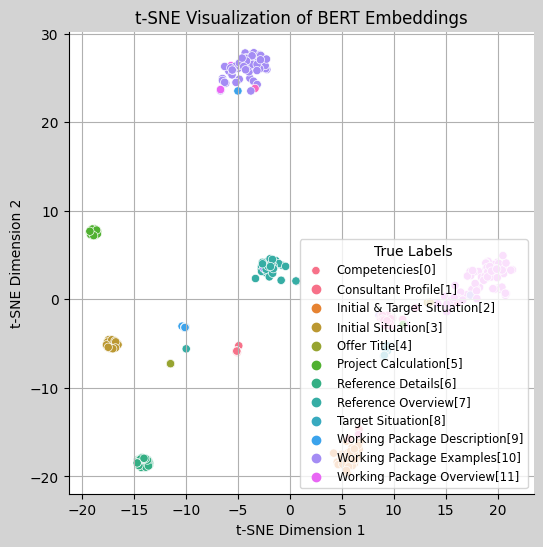

In [28]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
# Concatenate the embeddings and labels
embeddings = np.concatenate(predictions)
hue_labels = np.concatenate(true_labels)

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Map true labels to corresponding class names
class_names = ['Competencies[0]', 'Consultant Profile[1]', 'Initial & Target Situation[2]',
               'Initial Situation[3]', 'Offer Title[4]', 'Project Calculation[5]',
               'Reference Details[6]', 'Reference Overview[7]', 'Target Situation[8]',
               'Working Package Description[9]', 'Working Package Examples[10]',
               'Working Package Overview[11]', 'Others[12]']

# Create a colormap for different classes
cmap = sns.color_palette("husl", n_colors=len(class_names))

# Use Seaborn to visualize the embeddings
plt.figure(figsize=(6, 6), facecolor='lightgray')  # 設定背景顏色為淺灰色
sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hue=hue_labels,
                palette=cmap, legend='full',)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of BERT Embeddings')
plt.grid(True)
sns.despine()  # Remove spines from plot

# Move the legend to the bottom right corner
plt.legend(title='True Labels', labels=class_names, fontsize='small', loc='lower right')

plt.show()

Calculating Matthews Corr. Coef. for each batch...
[0 6 9 6 1 6 1 7]
[0 6 9 6 1 6 1 7]
------
[ 1 10  9 10  6 10  4  9]
[ 1 10  9 10  6 10  4 10]
------
[ 8  2  2 10  6  6  5  1]
[ 8  2  2 10  6  6  5  1]
------
[ 2  3  3 10  5 10  9 10]
[ 2  3  3 10  5 10  9  2]
------
[11 10  0 10  6 10  1  5]
[11 10  0 10  6 10  1  5]
------
[ 4  9  2 10  5  8  9 10]
[ 4  9  2 10  5  8  9 10]
------
[ 1  8  2  9  6  1 10  9]
[ 1  8  2  9  6  1 10  9]
------
[ 7 11 10 10  0  5  9  0]
[ 7 11 10 10  0  5  9  0]
------
[ 1  9  4 10 10  1  1  1]
[ 1  9  4 10 10  0  1  1]
------
[ 4 10  2  5  7  2  9  9]
[ 4 10  2  5  7  2  9  9]
------
[ 8 11  9  0  3  5  9  7]
[ 8 11  9  0  3  5  9  7]
------
[ 5  9  6  9  2  1 10  7]
[ 5  9  6  9  2  1 10  7]
------
[ 4  5  4  6 10 11  2 10]
[ 4  5  4  6 10 11  2 10]
------
[11  6  5  1  5  3  4  9]
[11  6  5  1  5  3  4  9]
------
[10  2  3 10  0  1  6  1]
[10  2  3 10  0  1  9  1]
------
[ 2  5  6  5 10  9  5 10]
[ 2  5  6  5 10 10  5 10]
------
[ 4  9  8 10  8  6  2

C:\Users\Kun\AppData\Local\Temp\ipykernel_23392\3395681127.py:32: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)


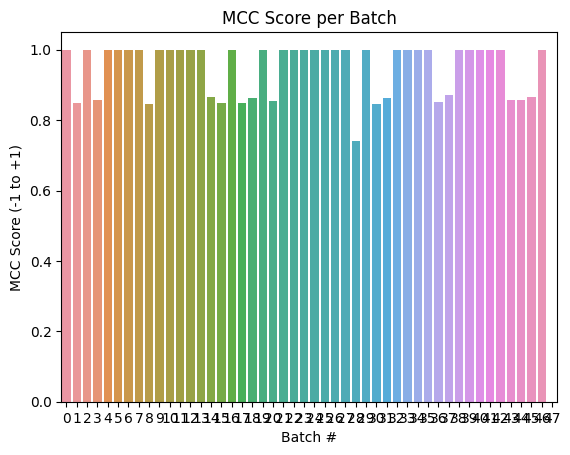

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import matthews_corrcoef

matthews_set = []

ground_true = []
preds = []
# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input BATCH...
for i in range(len(true_labels)):

  # The predictions for this batch are a 2-column ndarray (one column for "0"
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

  # Calculate and store the coef for this batch.
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
  matthews_set.append(matthews)
  print(pred_labels_i)
  print(true_labels[i])
  print('------')
  # extend for checking every label
  ground_true.extend(pred_labels_i)
  preds.extend(true_labels[i])

# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

In [30]:
# Combine the results across all batches.
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.949


In [31]:

# Generate the classification report
test_report = classification_report(ground_true, preds, digits = 4, target_names=['Competencies[0]',
                                                                      'Consultant Profile[1]',
                                                                      'Initial & Target Situation[2]',
                                                                      'Initial Situation[3]',
                                                                      'Offer Title[4]',
                                                                      'Project Calculation[5]',
                                                                      'Reference Details[6]',
                                                                      'Reference Overview[7]',
                                                                      'Target Situation[8]',
                                                                      'Working Package Description[9]',
                                                                      'Working Package Examples[10]',
                                                                      'Working Package Overview[11]',
                                                                      'Others[12]'])

# Print the classification report
print(test_report)

                                precision    recall  f1-score   support

               Competencies[0]     0.8667    1.0000    0.9286        13
         Consultant Profile[1]     1.0000    0.9286    0.9630        42
 Initial & Target Situation[2]     0.9333    1.0000    0.9655        28
          Initial Situation[3]     1.0000    1.0000    1.0000        12
                Offer Title[4]     0.9583    1.0000    0.9787        23
        Project Calculation[5]     1.0000    1.0000    1.0000        30
          Reference Details[6]     1.0000    0.9250    0.9610        40
         Reference Overview[7]     1.0000    1.0000    1.0000        13
           Target Situation[8]     0.9333    1.0000    0.9655        14
Working Package Description[9]     0.9322    0.9167    0.9244        60
  Working Package Examples[10]     0.9481    0.9481    0.9481        77
  Working Package Overview[11]     0.8846    0.9200    0.9020        25

                      accuracy                         0.9549 

# Single tests

In [ ]:
from PIL import Image, ImageDraw, ImageFont
QQ = []
# image = Image.open("/content/RVL_CDIP_one_example_per_class/resume/0000157402.tif")
for i in range(7,10):
  print(i)
  image = Image.open(f'FewWordImg/22647_Anlage1_Leistungsbeschreibung_KTR22647_{i}.PNG')
  image = image.convert("RGB")
  QQ.append(image)

7
8
9


In [ ]:
from transformers import LayoutLMv2Tokenizer, LayoutLMv2Processor
from transformers import LayoutLMv2FeatureExtractor, LayoutXLMTokenizerFast, LayoutXLMProcessor
from transformers import AutoTokenizer, AutoModelForSequenceClassification

import torch
feature_extractor = LayoutLMv2FeatureExtractor()
# tokenizer = LayoutLMv2Tokenizer.from_pretrained("microsoft/layoutlmv2-base-uncased")

tokenizer = LayoutXLMTokenizerFast.from_pretrained("SCUT-DLVCLab/lilt-infoxlm-base")
# processor = LayoutLMv2Processor(feature_extractor, tokenizer)
processor = LayoutXLMProcessor(feature_extractor, tokenizer)

for i in range(0, 3):
  encoded_inputs = processor(QQ[i],
                          return_tensors="pt",
                          max_length = 512,    # Pad & truncate all sentences.
                          padding = 'max_length',
                          truncation = True,
                      )
  # Save the encoded inputs
  torch.save(encoded_inputs, f"encoded_inputs_{i}.pt")



# processor.tokenizer.decode(encoded_inputs.input_ids.squeeze().tolist())

In [ ]:
encoded_inputs_ori = processor(QQ,
                            return_tensors="pt",
                            max_length = 512,    # Pad & truncate all sentences.
                            padding = 'max_length',
                            truncation = True,
                        )

In [ ]:
encoded_inputs_ori

{'input_ids': tensor([[     0,      6, 104328,  ...,      1,      1,      1],
        [     0,   8274,  63823,  ...,      1,      1,      1],
        [     0,  17198,     13,  ...,      1,      1,      1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'bbox': tensor([[[  0,   0,   0,   0],
         [ 31,  61, 104,  90],
         [ 31,  61, 104,  90],
         ...,
         [  0,   0,   0,   0],
         [  0,   0,   0,   0],
         [  0,   0,   0,   0]],

        [[  0,   0,   0,   0],
         [ 30,  61,  98,  90],
         [ 30,  61,  98,  90],
         ...,
         [  0,   0,   0,   0],
         [  0,   0,   0,   0],
         [  0,   0,   0,   0]],

        [[  0,   0,   0,   0],
         [ 32, 174,  86, 218],
         [ 32, 174,  86, 218],
         ...,
         [  0,   0,   0,   0],
         [  0,   0,   0,   0],
         [  0,   0,   0,   0]]]), 'image': tensor([[[[69, 70, 71,  ..., 60, 60, 60],
    

In [ ]:
from transformers import BatchEncoding
combined_encode_lists = []
for i in range(0, 3):
  LKK = torch.load(f"encoded_inputs_{i}.pt")
  combined_encode_lists.append(LKK)


merged_encoded_inputs = {
    key: torch.cat([enc_input[key] for enc_input in combined_encode_lists], dim=0)
    for key in combined_encode_lists[0].keys()
}


In [ ]:
processor.tokenizer.decode(LKK.input_ids.squeeze().tolist())

'<s> Projektvorgehen ‘APA: Grundlagen- ermittung Das Projekt wird sauber aufgesetztund die ermittett. Aufbau Projektorga- nisation, Zieldefintion und an den Ist Abgleich/Aufnahme Betriebemteln ink, Gebaudeanforderungen ten und Analyse der Informationen zu den Ziel Standorten a ‘AP2: Fabrikplanung Die Ziel-Standorte werden detailliert geplant, die jeweiligenLayouts gestatet und Gebaudeanforde- rungen abgeleitet. ordnung der Produktionsanlagen auf die Ziel-Standorte Planung des Produktions- und Lovisticsystems Planen der Layouts mit Anlagenautstelung Ableten von Gebaudeanforderungen Ubermitiung der Gebaudeanforderungen an die Zielstandorte auswahl Der Umzug wird detailliert geplant. Der Umzu: dienstleister wird strukturiert ausgewahit Tatigkeiten 4. Erstetung U 2. Erstelung U lastenneft Unterstitzung bei der reibung, Prifen der Anbieter, Auswahlder Dienstieter Es wird sichergestellt, dass die Mitarbeiterhinsichtlict Arbeitsanweisungen und Wartungsanweisung lt werden, Planung von Mitarbet

In [ ]:
for k,v in encoded_inputs.items():
  print(k, v.shape)

input_ids torch.Size([3, 256])
attention_mask torch.Size([3, 256])
bbox torch.Size([3, 256, 4])
image torch.Size([3, 3, 224, 224])
